# DEA CoastLines validation

To do:
* [X] Change output CRS to Australian Albers
* [X] Discard validation sides with multiple intersects?
* [X] Split analysis code into:
    * Aggregate multiple profiles and export into single file
    * Analyse and plot single file
* [ ] Add extraction of environmental data for each profile line

## Load modules/functions


In [2]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import sys
import glob
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import box

sys.path.append('/g/data/r78/rt1527/dea-notebooks/DEACoastLines/')
import deacoastlines_validation as deacl_val
import deacoastlines_statistics as deacl_stats

def to_vector(df, fname='test.shp', x='x', y='y', crs='EPSG:3577', output_crs='EPSG:3577'):
    
    # Convert datetimes to strings
    is_datetime = df.dtypes == 'datetime64[ns]'
    df.loc[:, is_datetime] = df.loc[:, is_datetime].astype(str) 
    
    # Export to file
    print('test')
    gdf = gpd.GeoDataFrame(data=df.loc[:, df.dtypes != 'datetime64[ns]'],
                     geometry=gpd.points_from_xy(x=df[x], y=df[y]),
                     crs=crs).to_crs(output_crs).to_file(fname)
    
    return gdf


def export_eval(df, output_name, output_crs='EPSG:3577'):
    
    from shapely.geometry import box, Point, LineString

    # Extract geometries
    val_points = gpd.points_from_xy(x=df.val_x, y=df.val_y)
    deacl_points = gpd.points_from_xy(x=df.deacl_x, y=df.deacl_y)
    df_profiles = df.groupby('id').first()
    profile_lines = df_profiles.apply(
        lambda x: LineString([(x.start_x, x.start_y), (x.end_x, x.end_y)]), axis=1)

    # Export validation points
    val_gdf = gpd.GeoDataFrame(data=df,
                               geometry=val_points,
                               crs=output_crs).to_crs('EPSG:4326')
    val_gdf.to_file(f'figures/eval/{output_name}_val.geojson', driver='GeoJSON')

    # Export DEACL points
    deacl_gdf = gpd.GeoDataFrame(data=df,
                                 geometry=deacl_points,
                                 crs=output_crs).to_crs('EPSG:4326')
    deacl_gdf.to_file(f'figures/eval/{output_name}_deacl.geojson', driver='GeoJSON')

    # Export profiles
    profile_gdf = gpd.GeoDataFrame(data=df_profiles,
                                 geometry=profile_lines,
                                 crs=output_crs).to_crs('EPSG:4326')
    profile_gdf.to_file(f'figures/eval/{output_name}_profiles.geojson', driver='GeoJSON')
    

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Analysis
To investigate:
* [X] Outlier in Bermagui (Horseshoe Bay)
* [X] **Multiple outliers in Boambee Beach**
* [X] Single remaining outlier in Bogangar to Kingscliff
* [X] **Cluster of outliers in Burgess Beach: caused by one year of channel profiles**
* [X] Sporadic outliers in Byron Bay
* [X] Two remaining outlier in Corindi Beach
* [X] **Major outliers at Crowdy Head**
* [X] **String of outliers in opposite direction at Cullendulla**
* [X] One remaining outlier at Diamond Beach
* [X] One remaining outlier at Eurobadalla Beaches North
* [ ] **Cluster of outliers at Evans Head and Broadwater**
* [X] Two outliers in Fern Bay
* [ ] **Extreme outliers at Flynn's Beach**
* [ ] **Skewed result at Gerringong Harbour**
* [ ] Outliers in Hargrave's Beach
* [ ] Remaining outliers at Jimmy's Beach
* [X] **Remaining major outlier at Lake Illawarra**
* [X] **Outliers in Manly Beach**
* [X] **Outliers at Mooney Beach**
* [X] **Major issues with offset shorelines at Narrabeen/Collory**
* [X] Outlier at Ocean View Beach
* [X] **Outliers in opposite direction at Park's Beach**
* [X] Cluster of outliers at Patch's Beach
* [X] Outliers at Port Hacking 
* [X] **Weird line of points at Rainbow Beach**
* [X] **No relationship at Sandbar Beach**
* [ ] Outliers at Shellharbour Little Lake
* [X] One remaining outlier at Stuart's Point
* [ ] **Several remaining outliers at Swansea Belmont**
* [X] **Cluster of outliers at The Entrance**
* [X] Single outlier at Warrain
* [ ] **Major issues with Valla Beach**

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

val_paths = glob.glob('output_data/cgc_*.csv')
deacl_path = '../packages/DEACoastLines_v0.2.0/DEACoastLines_coastlines_v0.2.0.shp'
# deacl_path = '../DEACoastLines_coastlines_v0.2.0_0.20.shp'

stats_list = []

for val_path in val_paths:
    
    # Run analysis and close resulting figure
    print(f'{val_path:<80}', end='\r')
    output_stats = deacl_val.deacl_validation(val_path, 
                                              deacl_path,
                                              datum=0)
    # Close figure if plotting over 10
    if len(stats_list) > 10: plt.close()
    
    # Append stats to list
    stats_list.append(output_stats)
    
# Combine stats into a dataframe
stats_df = pd.concat(stats_list)
stats_df.head()


IndexError: single positional indexer is out-of-bounds

In [148]:
# Export evaluation vectord
output_name = 'stirling'
export_eval(stats_df, output_name)
# stats_df.groupby('beach').apply(lambda x: export_eval(x, x.beach.iloc[0]))

MAE: 4.86 m
RMSE: 7.76 m
StDev: 7.66
Corr: 0.924
Mean offset: 8.54 m
50th perc diff: 9.29 m


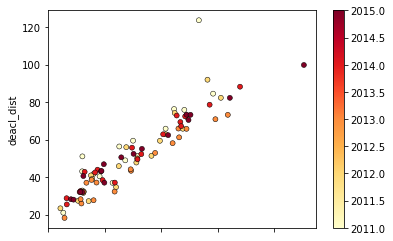

In [164]:
# Print stats and plot scatterplot
stats_subset = stats_df  #.loc[stats_df.beach=='wreckpoint']
# stats_subset['deacl_dist'] += 10
print(f'MAE: {mean_absolute_error(stats_subset.val_dist, stats_subset.deacl_dist):.2f} m\n'
      f'RMSE: {mean_squared_error(stats_subset.val_dist, stats_subset.deacl_dist)**0.5:.2f} m\n'
      f'StDev: {stats_subset[["diff_dist"]].std().iloc[0]:.2f}\n'
      f'Corr: {stats_subset[["val_dist", "deacl_dist"]].corr().iloc[0, 1]:.3f}\n'
      f'Mean offset: {stats_subset[["diff_dist"]].mean().iloc[0]:.2f} m\n'
      f'50th perc diff: {stats_subset["diff_dist"].abs().quantile(0.50):.2f} m')

stats_subset.plot.scatter(x='val_dist',
                      y='deacl_dist',
                      c=stats_subset.year,
                      s=25,
                      cmap='YlOrRd',
#                       vmin=1987,
#                       vmax=2018,
                      edgecolors='black',
                      linewidth=0.5)


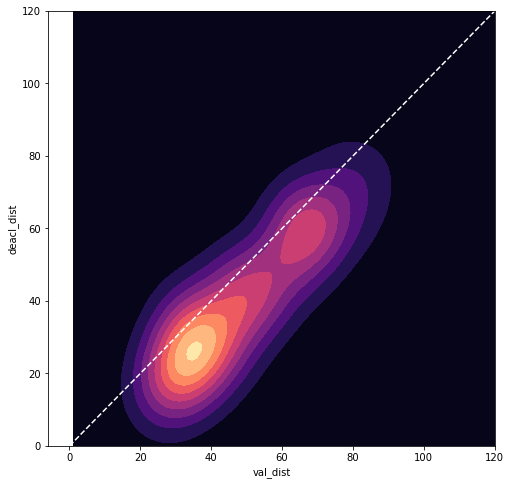

In [162]:
import seaborn as sns

extent = (0, 120)
fig, ax = plt.subplots(figsize=(8, 8))

sns.kdeplot(ax=ax,
            data=stats_df.val_dist,
            data2=stats_df.deacl_dist, 
            cmap='magma', 
            shade=True,
            clip=(extent, extent)
           )
plt.gca().plot(np.linspace(*extent), 
               np.linspace(*extent),
               color='white',
               linestyle='dashed')

In [745]:
to_vector(output_stats, fname='test6.shp', x='0_x', y='0_y', crs='EPSG:3577')

## Pre-processing


### Victoria/Deakin
* [X] Renovated

In [ ]:
deacl_val.preprocess_vicdeakin(fname='input_data/vicdeakin/z_data_10cm_VIC.csv',
                               datum=0)

### WRL Narrabeen 
* [X] Renovated

In [ ]:
deacl_val.preprocess_narrabeen(fname='input_data/wrl/Narrabeen_Profiles_2018.csv',
                               datum=0,
                               overwrite=True)


### NSW Beach Profile Database
* [X] Renovated

In [143]:
for fname in glob.glob('input_data/nswbpd/*.csv'):
    profiles_df = deacl_val.preprocess_nswbpd(fname, 
                                              datum=0, 
                                              overwrite=True)     


/g/data/v10/public/modules/dea-env/20200526/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):



Dropping invalid profiles: 19                                                                              
Processing output_data/nswbpd_brunswick.csv                                                
Dropping invalid profiles: 1                                                                               
Processing output_data/nswbpd_saphirebeach.csv                                             
Dropping invalid profiles: 13                                                                              
Processing output_data/nswbpd_ballina.csv                                                  
Dropping invalid profiles: 1                                                                               
Processing output_data/nswbpd_boambeebeach.csv                                             
Dropping invalid profiles: 9                                                                               
Processing output_data/nswbpd_saltsbay.csv                                                 

### City of Gold Coast
* [X] Renovated

In [4]:
# List of sites to iterate over
all_profiles = glob.glob(f'input_data/cityofgoldcoast/*.txt')
sites = np.unique([i.split(' - ')[0].split('/')[-1] for i in all_profiles])
# sites = ['SOUTH STRADBROKE']

for site in sites:
    deacl_val.preprocess_cgc(site=site, 
                             datum=0,
                             overwrite=True)

### TASMARC
* [X] Renovated

In [ ]:
# List of sites to iterate over
sites = [i.split('/')[2] for i in glob.glob('input_data/tasmarc/*/')]

for site in sites[3:4]:
    deacl_val.preprocess_tasmarc(site, overwrite=True) 


### WA DoT
* [X] Renovated

In [554]:
# Read in tertiary compartment file to regionalise results
# tertiary_gdf = gpd.read_file('input_data/WA_tertiaryCC.shp').to_crs('EPSG:3577')
tertiary_gdf = gpd.read_file('input_data/wa_sw.geojson').to_crs('EPSG:3577')
tertiary_gdf = tertiary_gdf.set_index('FROM_')

# Extract transects and validation distances
deacl_val.preprocess_wadot(regions_gdf=tertiary_gdf, 
                           fname='input_data/wadot/Coastline_Movements_20190819.gdb',
                           smartline='../input_data/Smartline.gdb',
                           aus_poly='/g/data/r78/rt1527/shapefiles/australia/australia/cstauscd_r.shp')

### WA DoT - Stirling

In [156]:
deacl_val.preprocess_stirling(fname_out='output_data/stirling_stirling.csv',
                              datum=0)

### SA Department of Environment and Water

In [ ]:
import math
from pyproj import Transformer

# Load data and set nodata values to NaN
wide_df = pd.read_csv('input_data/sadew/200011.CSV', na_values=[-9999])

# Reproject coords to Albers and create geodataframe
trans = Transformer.from_crs("EPSG:28354", "EPSG:28356", always_xy=True)
wide_df['EASTING'], wide_df['NORTHING'] = trans.transform(
    wide_df.EASTING.values, wide_df.NORTHING.values)

# Reshape into long format with each observation on a new row
profile_df = pd.melt(wide_df.drop('SAMPLE_NO', axis=1), 
                     id_vars=['EASTING', 'NORTHING', 'PROFILE'],
                     value_name='elevation').dropna()

# Set column names to lower case
profile_df.columns = profile_df.columns.str.lower()

# Extract date info
profile_df['date'] = profile_df['variable'].str[1:].str.strip()
profile_df['date'] = pd.to_datetime(profile_df['date'], format='%d%m%Y')

# Restrict to post 1987
profile_df = profile_df[(profile_df.date.dt.year > 1987)]

# Add unique ID column
profile_df['beach'] = 'sadew'
profile_df['section'] = 'all'
profile_df['profile'] = profile_df['profile'].astype(str)
profile_df['site'] = profile_df[['beach', 'section', 'profile']].apply('_'.join, 1)
profile_df['source'] = 'sadew'

# Compute origin points for each profile
profile_df = profile_df.assign(start_x=wide_df.iloc[0, 2], 
                               start_y=wide_df.iloc[0, 3],
                               end_x=wide_df.iloc[-1, 2],
                               end_y=wide_df.iloc[-1, 3])

# Compute chainage
profile_df['chainage'] = profile_df.apply(
    lambda x: math.hypot(x.easting - x.start_x, x.northing - x.start_y), axis=1)

In [ ]:
# Find location and distance to water for datum height (0 m AHD)
out = profile_df.groupby(['site', 'date']).apply(deacl_val.waterline_intercept, 
                                                  dist_col='chainage',
                                                  x_col='easting', 
                                                  y_col='northing', 
                                                  z_col='elevation', 
                                                  z_val=0).dropna()

# If the output contains data
if len(out.index):

    # Join into dataframe
    shoreline_dist = out.join(
        profile_df.groupby(['site', 'date']).first())

    # Keep required columns
    shoreline_dist = shoreline_dist[['beach', 'section', 'profile',  
                                     'source', 'start_x', 'start_y', 
                                     'end_x', 'end_y', '0_dist', 
                                     '0_x', '0_y']]

    # Export to file
    shoreline_dist.to_csv(f'output_data/satest.csv')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2020